# Importing Libraries

In [2]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import cv2
import pathlib
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

tf.random.set_seed(245)
os.environ['PYTHONHASHSEED'] = str(245)

In [ ]:
os.getcwd()

In [5]:
#define path path to dataset
data_dir = "/Users/monugoel/Desktop/KungFu Panda Screenshots/Data"

In [6]:
#go to dataset's directory, then list the directories (subfolders)
os.chdir(data_dir)
categories = os.listdir()
print(categories)

['.DS_Store', 'Mantis', 'MrPing', 'ShiFu', 'Crane', 'Tigress', 'Oogway', 'Po', 'Viper', 'Monkey', 'TaiLung']


In [7]:
data_dir = pathlib.Path(data_dir)
print(data_dir)

/Users/monugoel/Desktop/KungFu Panda Screenshots/Data


In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

262


# Creating DataStore

In [151]:
batch_size = 263
img_height = 1908
img_width = 1586

In [152]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 263 files belonging to 10 classes.
Using 211 files for training.


In [153]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(train_ds.class_names)

['Crane', 'Mantis', 'Monkey', 'MrPing', 'Oogway', 'Po', 'ShiFu', 'TaiLung', 'Tigress', 'Viper']


In [154]:
offset_height = 500
offset_width = 0
target_height = 980
target_width = 1586
func = tf.image.crop_to_bounding_box
train_ds = train_ds.map(lambda x,y: (func(x, offset_height, offset_width, target_height, target_width),y))

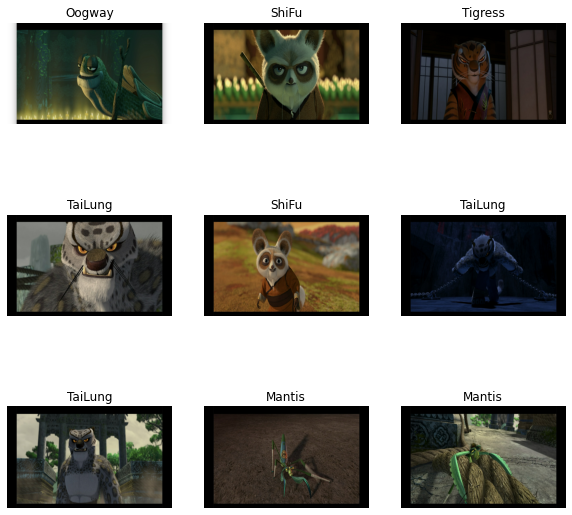

In [155]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [156]:
train_ds.take(1)

<TakeDataset shapes: ((None, 980, 1586, 3), (None,)), types: (tf.float32, tf.int32)>

In [157]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 263 files belonging to 10 classes.
Using 52 files for validation.


In [158]:
val_ds = val_ds.map(lambda x,y: (func(x, offset_height, offset_width, target_height, target_width),y))

In [159]:
img_height = 256
img_width = 256

func = tf.image.resize

train_ds = train_ds.map(lambda x,y: (func(x,[img_height,img_width], method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None),y))

In [160]:
val_ds = val_ds.map(lambda x,y: (func(x,[img_height,img_width], method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None),y))

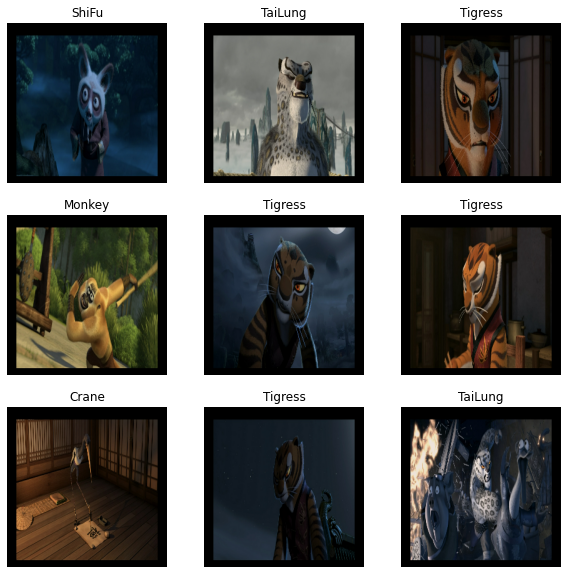

In [162]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [163]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [164]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [117]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#why do we need the normalized_ds?
#map() function allows you to process all the data in an iterable object without using a loop, maybe use the crop_and_resize function with map()
#function to crop images: tf.image.crop_and_resize

#train_ds = train_ds.map(lambda x,y: (crop_and_resize(x),y))
#same for val_ds
image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]


#NUM_BOXES = 5
#CHANNELS = 3
#tf.image.crop_and_resize([image_batch, img_height, img_width, 3], )

plt.imshow(first_image) #show's first image, need to crop images ([50:200], [20:220])



print("image_batch type:" + str(type(image_batch)))
print("first_image type: " + str(type(first_image)))

# Notice the pixels values are now in `[0,1]`. Why do you make pixel values go from 0 to 1?

print(np.min(first_image), np.max(first_image))

NameError: name 'first_image' is not defined

In [177]:
#Simple CNN:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

layers.Conv2D() function creates the convolution layer


In [178]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0009)
model.compile(optimizer=adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [179]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 64)       

In [180]:
epochs=30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
1/1 [==============================] - 5s 5s/step - loss: 2.3034 - accuracy: 0.1137 - val_loss: 1.9697 - val_accuracy: 0.3654
Epoch 2/30
1/1 [==============================] - 5s 5s/step - loss: 2.1976 - accuracy: 0.1659 - val_loss: 2.2732 - val_accuracy: 0.2115
Epoch 3/30
1/1 [==============================] - 5s 5s/step - loss: 2.1234 - accuracy: 0.3081 - val_loss: 2.1708 - val_accuracy: 0.2115
Epoch 4/30
1/1 [==============================] - 5s 5s/step - loss: 2.0471 - accuracy: 0.3128 - val_loss: 2.0489 - val_accuracy: 0.3269
Epoch 5/30
1/1 [==============================] - 5s 5s/step - loss: 1.9604 - accuracy: 0.4645 - val_loss: 1.8739 - val_accuracy: 0.3654
Epoch 6/30
1/1 [==============================] - 5s 5s/step - loss: 1.8159 - accuracy: 0.4313 - val_loss: 1.7731 - val_accuracy: 0.4038
Epoch 7/30
1/1 [==============================] - 5s 5s/step - loss: 1.7012 - accuracy: 0.4265 - val_loss: 1.9516 - val_accuracy: 0.3077
Epoch 8/30
1/1 [=========================

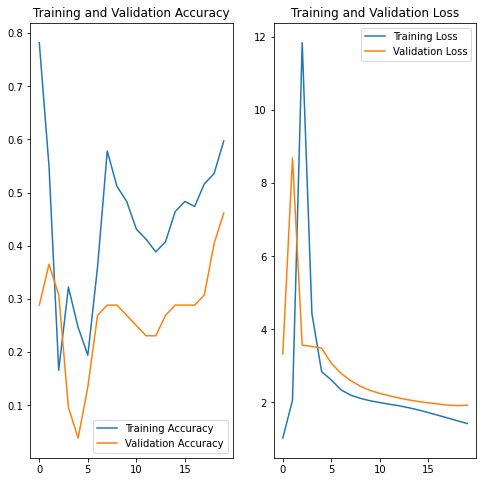

In [172]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()